# XGBoost

[XGBoost](https://xgboost.readthedocs.io/), or `eXtreme Gradient Boosting`, is gradient boosting library. Although `scikit-learn` has several [boosting algorithms available](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble), XGBoost's implementations are parallelized and takes advantage of GPU computing. A few of the types of learners XGBoost has include gradient boosting for regression, classification and survival analysis (e.g. Accelerated Failure Time `AFT`). There are no shortages of boosting libraries; here's a few more.

- [LightGBM](https://lightgbm.readthedocs.io)
- [CatBoost](https://catboost.ai/)

## Regression

Let's see how XGBoost works on regression problems by first simulating data.

In [1]:
import numpy as np
import random 
from sklearn.datasets import make_regression

random.seed(37)
np.random.seed(37)

X, y = make_regression(**{
    'n_samples': 1000,
    'n_features': 10,
    'n_targets': 1,
    'bias': 5.3,
    'random_state': 37
})

print(f'X shape = {X.shape}, y shape {y.shape}')

X shape = (1000, 10), y shape (1000,)


We will split the generated data into training and testing sets.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37) 

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 10) (800,)
(200, 10) (200,)


The `XGBRegressor` class is used to learn a boosted regression model. Note that the objective is specified to `reg:squarederror`. A list of objectives is [available](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters). Here, we specify only 10 estimators.

In [3]:
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, seed=37) 
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=12, num_parallel_tree=1, random_state=37,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=37,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

We will measure the performance of the model using `mean absolute error` (MAE) and `root mean squared error` (RMSE).

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(mae)
print(rmse)

35.00964208044854
44.165107049077356


As you increase the number of estimators, the performance should increase, as measured by `MAE` and `RMSE`. There is a point of diminishing returns, however.

In [5]:
import pandas as pd

def get_performance(n_estimators):
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators, seed=37) 
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return {'mae': mae, 'rmse': rmse}

n_estimators = list(range(10, 101, 1))
results = pd.DataFrame([get_performance(n) for n in n_estimators], index=n_estimators)

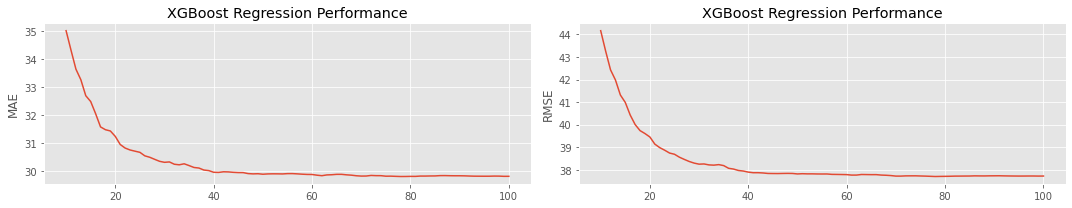

In [6]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

_ = results.mae.plot(ax=axes[0])
_ = results.rmse.plot(ax=axes[1])

axes[0].set_title('XGBoost Regression Performance')
axes[1].set_title('XGBoost Regression Performance')

axes[0].set_ylabel('MAE')
axes[1].set_ylabel('RMSE')

plt.tight_layout()

## Classification

Let's turn our attention to using XGBoost for classification by generating data for a classification problem.

In [7]:
from sklearn.datasets import make_classification

X, y = make_classification(**{
    'n_samples': 2000,
    'n_features': 20,
    'n_informative': 10,
    'n_redundant': 0,
    'n_repeated': 0,
    'n_classes': 2,
    'random_state': 37
})

print(f'X shape = {X.shape}, y shape {y.shape}')

X shape = (2000, 20), y shape (2000,)


We will split the data into training and testing sets.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37) 

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1600, 20) (1600,)
(400, 20) (400,)


The input data must be transformed from numpy arrays into `DMatrix`. 

In [9]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

print(dtrain.num_row(), dtrain.num_col())
print(dtest.num_row(), dtest.num_col())

1600 20
400 20


Now we are ready to learn a classification model with XGBoost.

In [10]:
param = {
    'max_depth':2, 
    'eta':1, 
    'objective':'binary:logistic', 
    'eval_metric': 'logloss', 
    'seed': 37
}
num_round = 20

model = xgb.train(param, dtrain, num_round)

We will measure the performance of the model using `Area Under the Curve` (the Receiver Operating Characteristic curve) and the `Average Precision Score`. 

In [11]:
from sklearn.metrics import roc_auc_score, average_precision_score

y_pred = model.predict(dtest)

auc = roc_auc_score(y_test, y_pred)
aps = average_precision_score(y_test, y_pred)

print(auc)
print(aps)

0.951115116017121
0.9450649144817633


## Survival

Let's see how survival regression works with XGBoost. Let's sample some data. 

In [12]:
X, y = make_regression(**{
    'n_samples': 1000,
    'n_features': 4,
    'n_targets': 0,
    'random_state': 37
})

coef = np.array([2.0, -1.0, 3.5, 4.4])
baseline = np.e / np.power(1 + np.e, 2.0)
y = np.exp(-X.dot(coef)) * baseline

print(f'X shape = {X.shape}, y shape {y.shape}, coef shape = {coef.shape}')

X shape = (1000, 4), y shape (1000,), coef shape = (4,)


Here, we will split the data into training and testing sets.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37) 

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 4) (800,)
(200, 4) (200,)


Let's turn the inputs into the appropriate format. Note that we do not supply the duration into the `DMatrix` but set the lower and upper bound using the `set_float_info()` method.

In [14]:
dtrain = xgb.DMatrix(X_train)
dtest = xgb.DMatrix(X_test)

dtrain.set_float_info('label_lower_bound', y_train)
dtest.set_float_info('label_lower_bound', y_test)

dtrain.set_float_info('label_upper_bound', y_train)
dtest.set_float_info('label_upper_bound', y_test)

print(dtrain.num_row(), dtrain.num_col())
print(dtest.num_row(), dtest.num_col())

800 4
200 4


The following shows how to specify a survival model with AFT.

In [15]:
params = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'logistic',
    'aft_loss_distribution_scale': 1.0,
    'tree_method': 'exact', 
    'learning_rate': 0.05, 
    'max_depth': 5
}
model = xgb.train(params, dtrain, num_boost_round=40, evals=[(dtrain, 'train')])

[0]	train-aft-nloglik:2.58474
[1]	train-aft-nloglik:2.13443
[2]	train-aft-nloglik:1.76805
[3]	train-aft-nloglik:1.51551
[4]	train-aft-nloglik:1.30791
[5]	train-aft-nloglik:1.15456
[6]	train-aft-nloglik:1.01593
[7]	train-aft-nloglik:0.90408
[8]	train-aft-nloglik:0.80288
[9]	train-aft-nloglik:0.71937
[10]	train-aft-nloglik:0.64163
[11]	train-aft-nloglik:0.57327
[12]	train-aft-nloglik:0.51536
[13]	train-aft-nloglik:0.46241
[14]	train-aft-nloglik:0.41428
[15]	train-aft-nloglik:0.37151
[16]	train-aft-nloglik:0.33085
[17]	train-aft-nloglik:0.29569
[18]	train-aft-nloglik:0.26403
[19]	train-aft-nloglik:0.23559
[20]	train-aft-nloglik:0.20816
[21]	train-aft-nloglik:0.18294
[22]	train-aft-nloglik:0.16056
[23]	train-aft-nloglik:0.13968
[24]	train-aft-nloglik:0.11968
[25]	train-aft-nloglik:0.10160
[26]	train-aft-nloglik:0.08428
[27]	train-aft-nloglik:0.06922
[28]	train-aft-nloglik:0.05431
[29]	train-aft-nloglik:0.04075
[30]	train-aft-nloglik:0.02782
[31]	train-aft-nloglik:0.01519
[32]	train-aft-nlo

Below, we evaluate the model using the [c-index](https://medium.com/analytics-vidhya/concordance-index-72298c11eac7).

In [16]:
from itertools import combinations

def get_status(p1, p2):
    x1, y1 = p1[0], p1[1]
    x2, y2 = p2[0], p2[1]
    
    r = (y2 - y1) * (x2 - x1)
    
    if r > 0:
        return 1
    elif r < 0:
        return -1
    else:
        return 0
    
y_pred = model.predict(dtest)
pairs = combinations([(y_t, y_p) for y_t, y_p in zip(y_test, y_pred)], 2)
results = [get_status(p1, p2) for p1, p2 in pairs]
c = sum([1 for r in results if r == 1])
n = len(results)
print(c / n)

0.9332160804020101


The c-index of the predictions from the training is as expected; it's higher than the testing set.

In [17]:
y_pred = model.predict(dtrain)

pairs = combinations([(y_t, y_p) for y_t, y_p in zip(y_train, y_pred)], 2)
results = [get_status(p1, p2) for p1, p2 in pairs]
c = sum([1 for r in results if r == 1])
n = len(results)
print(c / n)

0.9664893617021276
